<h1>Sieci neuronowe - ćwiczenie 3</h1>

In [1]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [3]:
def sigmoid(n) -> float:
    return 1 / (1 + np.exp(-n))

In [4]:
def sigmoid_der(n) -> float:
    return sigmoid(n) * (1 - sigmoid(n))

In [25]:
class Neuron:
    _weights: np.ndarray
    _bias: float
    _cache_x: np.ndarray
    _err: np.ndarray 

    def init_weights(self, size: int, std_dev: float):
        self._weights = np.random.normal(scale=std_dev, size=size) # initialize weights 
        self._bias = np.random.normal(scale=std_dev) #initialize bias 

    def forward(self, x: np.ndarray) -> np.ndarray:
       self._cache_x = x
       return sigmoid(np.dot(x, self._weights) + self._bias)
    
    def backward(self, error: np.ndarray):
       self._err = error * sigmoid_der(np.dot(self._cache_x, self._weights) + self._bias) 
       return self._err
    
    def backward_weights(self, error: np.ndarray, next_weights: np.ndarray):
       error = error.T @ next_weights
       self._err = error * sigmoid_der(np.dot(self._cache_x, self._weights) + self._bias) 
       return self._err

    def update_weights(self, learning_rate: float):
      self._weights = self._weights - learning_rate * np.dot(self._cache_x.T, self._err)
      self._bias = self._bias - learning_rate * np.sum(self._err)

    def get_weights(self):
       return self._weights  

    def get_bias(self):
       return self._bias  

class MultilayerNetwork:

   def __cross_entropy_loss(self, y: np.ndarray, y_pred:np.ndarray) -> np.ndarray:
      return -y*np.log(y_pred) - (1 - y)*np.log(1 - y_pred)
   
   def __cross_entropy_loss_der(self, y: np.ndarray, y_pred:np.ndarray) -> np.ndarray:
      return -np.sum(y / y_pred - (1 - y) / (1 - y_pred), axis=1)

   def __init__(self, hidden_layers_sizes = (1,) ):
      self._layers: list[list[Neuron]] = []
   
      for index, layer_size in enumerate(hidden_layers_sizes):
         self._layers.append([])
         for _ in range(layer_size):
            self._layers[index].append(Neuron()) 
      
      # output layer
      self._layers.append([])
      self._layers[-1].append(Neuron())

   def __get_weights(self) -> []:
      weights = []
      for layer in self._layers:
         weights.append([neuron.get_weights() for neuron in layer])     
      return weights
    
   def __get_biases(self) -> []:
      biases = []
      for layer in self._layers:
         biases.append([neuron.get_bias() for neuron in layer])     
      return biases 
   
   def __optimize(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int, learning_rate: float, 
                        max_iter: int) -> (list, list, list, list, list, list, list, list):
      losses = []
      weights = []
      biases = []
      losses_test = []

      accuracy = []
      f_score = []
      precision = []
      recalls = []

      if batch_size > x_train.shape[0]:
         batch_size = x_train.shape[0]

      for index in range(max_iter): #learn for max_iter      
         shuffle = np.random.permutation(x_train.shape[0])
         x_train_shuffled = x_train[shuffle]
         y_train_shuffled = y_train[shuffle]

         new_train_loss = 0
         for batch_start_index in range(0, x_train.shape[0], batch_size):
            x_train_batch = x_train_shuffled[batch_start_index:batch_start_index+batch_size] 
            y_train_batch = y_train_shuffled[batch_start_index:batch_start_index+batch_size] 

            pred = self.forward(x_train_batch)
            self.backward(y_train_batch, pred)

            for layer in self._layers:
               for neuron in layer:
                  neuron.update_weights(learning_rate)
                  
         #calculate loss of training data
         new_train_loss = np.mean(self.__cross_entropy_loss(y_train_batch, pred))
         
         #calculate loss of test data
         test_pred = self.predict(x_test)
         new_test_loss = np.mean(self.__cross_entropy_loss(y_test, test_pred))

         #append to helper lists
         losses.append(new_train_loss)
         weights.append(self.__get_weights)
         biases.append(self.__get_biases)
         losses_test.append(new_test_loss)

         test_pred[test_pred >= 0.5] = 1
         test_pred[test_pred < 0.5] = 0

         #calculate scores for each iteration
         accuracy.append(metrics.accuracy_score(y_test, test_pred))
         f_score.append(metrics.f1_score(y_test, test_pred))
         precision.append(metrics.precision_score(y_test, test_pred))
         recalls.append(metrics.recall_score(y_test, test_pred))



      return losses, weights, biases, losses_test, accuracy, f_score, precision, recalls

   def logarithmicRegression(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int, learning_rate: float, 
                       max_iter: int, std_dev: float, verb: bool = False) -> (list, list, list, list, list, list, list, list):
      
      curr_size_layer = x_train.shape[1]
      
      for layer in self._layers:
         for neuron in layer:
           neuron.init_weights(curr_size_layer, std_dev) 
         curr_size_layer = len(layer)
      
      #fix shape of y data to match further calculations
      # if len(y_test.shape) == 1:
      #    y_test = y_test[np.newaxis].T 

      # if len(y_train.shape) == 1:
      #    y_train = y_train[np.newaxis].T

      losses, weights, biases, losses_test, accuracy, f_score, precision, recalls = self.__optimize(x_train, y_train, x_test, y_test, batch_size, learning_rate, max_iter) #optimize weights and bias using training data

      if verb:
         #plot results
         plt.plot(np.arange(len(losses)), losses, label="Train Loss")
         plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
         plt.legend()
         plt.show()

      #print final weight, bias, loss and scores
         print("Weights: ", self.__get_weights())
         print("Bias: ", self.__get_biases())
         
      print("Train loss: ", losses[-1])
      print("Test loss: ", losses_test[-1])

      print("Scores")
      print("Accuracy: ", accuracy[-1])
      print("F_score: ", f_score[-1])
      print("Precision: ", precision[-1])
      print("Recall: ", recalls[-1])

      return losses, weights, biases, losses_test, accuracy, f_score, precision, recalls      
      
   def forward(self, x: np.ndarray) -> float:
      for layer in self._layers:
         x = np.array([neuron.forward(x) for neuron in layer]).T
      return x

   def backward(self, y_train: np.ndarray, y_pred: np.ndarray) -> list[list[np.ndarray[float]]]:
      err = np.array([out_neuron.backward(self.__cross_entropy_loss_der(y_train, y_pred)) for out_neuron in self._layers[-1]])
      next_weights = np.array([out_neuron.get_weights() for out_neuron in self._layers[-1]]).T

      for layer in reversed(self._layers[:-1]):
         err = np.array([neuron.backward_weights(err, next_weights[neuron_index]) for neuron_index, neuron in enumerate(layer)])
         next_weights = np.array([neuron.get_weights() for neuron in layer]).T
         

   def predict(self, x_test: np.ndarray) -> np.ndarray:
      return self.forward(x_test) 
    


<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [6]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [7]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance

result = std_features
result["heart_disease"] = df["num"]

# data not standarized 4. Danych znormalizowanych i nieznormalizowanych
n_std_result = df_without_num
n_std_result["heart_disease"] = df["num"]

result

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.886823,0.68658,-2.215399,0.715032,-0.287765,2.379535,0.976604,0.059922,-0.715498,1.022215,2.201942,-0.749379,0.620982,0
1,1.333084,0.68658,0.881638,1.544494,0.720661,-0.418716,0.976604,-1.759564,1.392528,0.346289,0.597335,2.409541,-0.921154,1
2,1.333084,0.68658,0.881638,-0.667404,-0.363872,-0.418716,0.976604,-0.849821,1.392528,1.275687,0.597335,1.356568,1.135027,1
3,-2.013877,0.68658,-0.150707,-0.114429,0.035693,-0.418716,-1.035347,1.662803,-0.715498,2.036103,2.201942,-0.749379,-0.921154,0
4,-1.567616,-1.45118,-1.183053,-0.114429,-0.839545,-0.418716,0.976604,1.012986,-0.715498,0.261798,-1.007271,-0.749379,-0.921154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.217430,-1.45118,0.881638,0.438545,-0.135549,-0.418716,-1.035347,-1.109747,1.392528,-0.752091,0.597335,-0.749379,1.135027,1
270,-1.121354,0.68658,-2.215399,-1.220378,0.302069,-0.418716,-1.035347,-0.719857,-0.715498,0.092816,0.597335,-0.749379,1.135027,1
271,1.444650,0.68658,0.881638,0.659735,-1.048841,2.379535,-1.035347,-0.329968,-0.715498,1.951613,0.597335,1.356568,1.135027,1
272,0.217430,0.68658,0.881638,-0.114429,-2.228508,-0.418716,-1.035347,-1.456316,1.392528,0.092816,0.597335,0.303594,1.135027,1


In [8]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [9]:
features = result.loc[:, result.columns != "heart_disease"].to_numpy()
targets = result["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

<h1>Testowanie modelu</h1>

In [19]:
#1. Różnej wymiarowości warstwy ukrytej
hidden1 = (4, 3)
hidden2 = (20, 10)
hidden3 = (100, 50)

#2. Różnej wartości współczynnika uczenia
learning1 = 0.005
learning2 = 0.001

#3. Różnych odchyleń standardowych przy inicjalizacji wag
std_dev = 0.8
std_dev = 0.3

#5. Różnej liczby warstw
hidden4 = (20)
hidden5 = (20, 20)
hidden6 = (20, 20, 20)

max_iter = 1000

<p>#1. Różnej wymiarowości warstwy ukrytej</p>

In [17]:
ex1 = MultilayerNetwork(hidden1)
ex2 = MultilayerNetwork(hidden2)
ex3 = MultilayerNetwork(hidden3)

r = ex1.logarithmicRegression(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)
r = ex2.logarithmicRegression(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)
r = ex3.logarithmicRegression(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)

Train loss:  0.6924365990360462
Test loss:  0.6932448862211074
Scores
Accuracy:  0.4939759036144578
F_score:  0.6612903225806451
Precision:  0.4939759036144578
Recall:  1.0
Train loss:  0.7121759465150594
Test loss:  0.695066656799082
Scores
Accuracy:  0.4939759036144578
F_score:  0.6612903225806451
Precision:  0.4939759036144578
Recall:  1.0


/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train loss:  0.6943989333920574
Test loss:  0.6933159265708222
Scores
Accuracy:  0.4939759036144578
F_score:  0.6612903225806451
Precision:  0.4939759036144578
Recall:  1.0


<p>#2. Różnej wartości współczynnika uczenia</p>

/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.

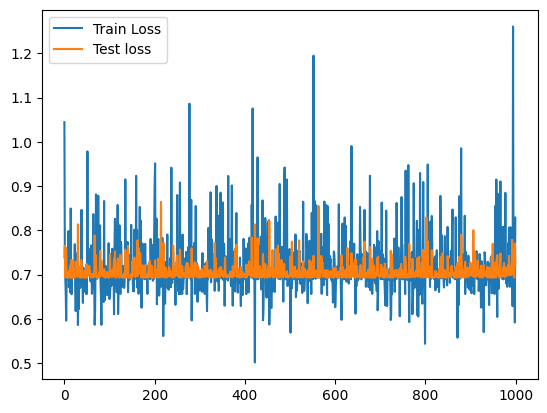

Weights:  [[array([-0.22452946, -0.05011588, -0.67992824, -0.02715941, -0.02704102,
        0.00200688, -0.07362055, -0.24612629,  0.15188942, -0.56025054,
       -0.12205678, -0.1173589 , -0.42920015]), array([-0.29846518, -0.46946174, -0.96931074, -0.41621526,  0.23864853,
        0.26802478, -0.06670458,  0.1248671 , -0.89134257,  0.14905642,
       -0.35405009, -0.32757341, -0.84035594]), array([ 0.12259412, -0.05441394, -0.0290252 , -0.0046582 , -0.0637597 ,
        0.5964047 , -0.01104743,  0.23897076, -0.14599632,  0.60170299,
        0.01554177, -0.29050717, -0.07681789]), array([-0.72754185, -0.16434214, -0.23411873,  0.00882727, -0.14195148,
       -0.22973257, -0.2931035 ,  0.40521092, -0.25626417, -0.47197047,
       -0.84345836, -0.40904202, -0.23390455])], [array([-1.31856578, -1.57918236, -0.79745284, -0.79171971]), array([-1.20085553, -1.05478895, -0.82950936, -0.79869639]), array([-0.97143338, -1.49167435, -1.00853611, -0.75089396])], [array([0.7901905 , 0.71301109, 0.

/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szymon/.pyenv/versions/3.10.6/lib/python3.

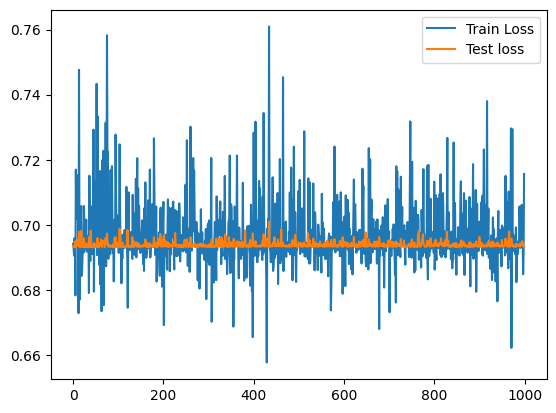

Weights:  [[array([ 0.3618078 , -0.34108088, -0.83949549, -0.62731223,  0.34993187,
       -0.50175186, -0.04297196,  0.44898623,  0.04065154, -0.3806731 ,
        0.15799685, -0.23722772, -0.56439946]), array([ 0.24644134, -0.18688399, -0.11234276,  0.14415581, -0.36828161,
        0.7523268 , -0.78888153,  0.22588691,  0.04090209, -0.64046098,
       -0.61785096,  0.22198502, -0.28918328]), array([-0.73589951,  0.2779311 ,  0.098254  , -0.01843371, -0.33169383,
        0.34430381,  0.41096273,  0.19730326, -0.49989275,  0.05802088,
        0.41808579, -0.12317903, -0.39516761]), array([-0.11893545, -0.18160167,  0.08893144,  0.0043421 , -0.10703584,
        0.37808563, -0.22400422,  0.26727939, -0.41544889,  0.5797661 ,
       -0.57954698, -0.21080209, -0.89437343])], [array([-0.73967831, -0.8808467 , -0.40083794, -0.47080304]), array([-0.31151207, -0.2735252 , -0.40464189, -0.6697079 ]), array([-0.89808643, -0.84853928, -0.7340016 , -0.36732736])], [array([0.1179789 , 0.1254448 , 0.

In [26]:
ex1 = MultilayerNetwork(hidden1)
ex2 = MultilayerNetwork(hidden1)

r = ex1.logarithmicRegression(x_train, y_train, x_test, y_test, 30, learning1, max_iter, 0.4, verb=True)
r = ex2.logarithmicRegression(x_train, y_train, x_test, y_test, 30, learning2, max_iter, 0.4, verb=True)